In [158]:
# Set things up

# Make Matplotlib to work with Jupyter Notebook
%matplotlib inline

# Ignore ugly DeprecationWarnings
#from bokeh import BokehDeprecationWarning
#import warnings
#warnings.filterwarnings("ignore", category=BokehDeprecationWarning)

import datetime
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from bokeh.io import output_notebook
from bokeh.plotting import show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, DataRange1d, HoverTool, PanTool, WheelZoomTool
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models.widgets import DateFormatter, StringFormatter
from bokeh.plotting import figure
import folium
from sklearn.cluster import DBSCAN
#from shapely.geometry import MultiPoint
from geopy.distance import great_circle

plt.style.use('ggplot')  # Change Matplotlib style to something nicer
plt.rc('font', size=12)  # Set default Matplotlib font size
output_notebook(hide_banner=True)  # Make Bokeh to work with Jupyter Notebook

# Define colors
COLOR_DARK = "#212121"
COLOR_YELLOW = "#ffb700"
# Define custom colormap
plt.register_cmap(cmap=colors.LinearSegmentedColormap.from_list(
    'TaxiYellow', ["#ffffff", COLOR_YELLOW]))

In [159]:
train = pd.read_csv(filepath_or_buffer="E:/1Prep for data science/capstone-1/train.csv", index_col='id',
                    parse_dates=['pickup_datetime', 'dropoff_datetime'],
                    infer_datetime_format=True)



In [160]:
test = pd.read_csv(filepath_or_buffer="E:/1Prep for data science/capstone-1/test.csv", index_col='id',
                    parse_dates=['pickup_datetime'],
                    infer_datetime_format=True)

## Shape of data and missing values info before cleanup

In [161]:
n_train_rows, n_train_cols = train.shape
n_test_rows, n_test_cols = test.shape
print('- Training data has {:9,} rows and {:2,} columns.'.format(*train.shape))
print('- Testing data has  {:9,} rows and {:2,} columns.'.format(*test.shape))

- Training data has 1,458,644 rows and 10 columns.
- Testing data has    625,134 rows and  8 columns.


## Cleaning up trip duration
As we noted earlier there are some outliers associated with the `trip_duration` variable, specifically a 980 hour maximum trip duration and a minimum of 1 second trip duration. I've decided to exclude data that lies outside 2 standard deviations from the mean. It might be worthwhile looking into what effect excluding up to 4 standard deviations would have on the end-results.

In [87]:
#m = np.mean(train['trip_duration'])
#s = np.std(train['trip_duration'])
#train = train[train['trip_duration'] <= m + 2*s]
#train = train[train['trip_duration'] >= m - 2*s]

In [162]:
n_train_rows, n_train_cols = train.shape
n_test_rows, n_test_cols = test.shape
print('- Training data has {:9,} rows and {:2,} columns.'.format(*train.shape))
print('- Testing data has  {:9,} rows and {:2,} columns.'.format(*test.shape))
print('- There are {:.1f} times more (#{:,}) training data examples than '
      'testing data examples.'.format(n_train_rows / n_test_rows,
                                        n_train_rows - n_test_rows))
print("- There are %i missing values in the training data." % train.isnull().sum().sum())
print("- There are %i missing values in the testing data." % test.isnull().sum().sum())

- Training data has 1,458,644 rows and 10 columns.
- Testing data has    625,134 rows and  8 columns.
- There are 2.3 times more (#833,510) training data examples than testing data examples.
- There are 0 missing values in the training data.
- There are 0 missing values in the testing data.


## Latitude and Longitude Clean-up


Looking into it, the borders of NY City, in coordinates comes out to be:

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 

Comparing this to our `train.describe()` output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.

In [163]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

Next, let's show the beginning of each dataset in an interactive Bokeh table and visualize the number of examples in each dataset with a bar chart.

In [164]:
print("The first 10 rows of the training data shown in an interactive Bokeh table:")
show(DataTable(
    source=ColumnDataSource(train.head(10)), editable=True,
    columns=[TableColumn(
        field=c, title=c,
        formatter=DateFormatter() if 'datetime' in c else StringFormatter())
        for c in train.columns],
    width=820, height=300))

# -----------------------------------------------------------------------------


The first 10 rows of the training data shown in an interactive Bokeh table:


In [165]:

print("The first 10 rows of the testing data shown in an interactive Bokeh table:")
show(DataTable(
    source=ColumnDataSource(test.head(10)),
    columns=[TableColumn(
        field=c, title=c,
        formatter=DateFormatter() if 'datetime' in c else StringFormatter())
        for c in test.columns],
    width=820, height=300))


The first 10 rows of the testing data shown in an interactive Bokeh table:


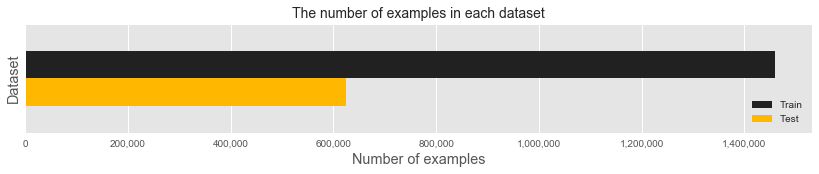

In [166]:
ax = pd.DataFrame({'Train': [n_train_rows], 'Test': [n_test_rows]}).plot.barh(
    figsize=(14.1, 2), legend='reverse', rot=90, color=[COLOR_YELLOW, COLOR_DARK])
ax.set(xlabel='Number of examples', ylabel='Dataset')
ax.set_title('The number of examples in each dataset', fontsize=14)
ax.get_yaxis().set_ticks([])
# For readability, add commas to separate thousand in the x-axis labels
ax.set_xticklabels([format(label, ',.0f') for label in ax.get_xticks()]);

# Visualizing the distributions of some variables in training and testing data by bar charts.

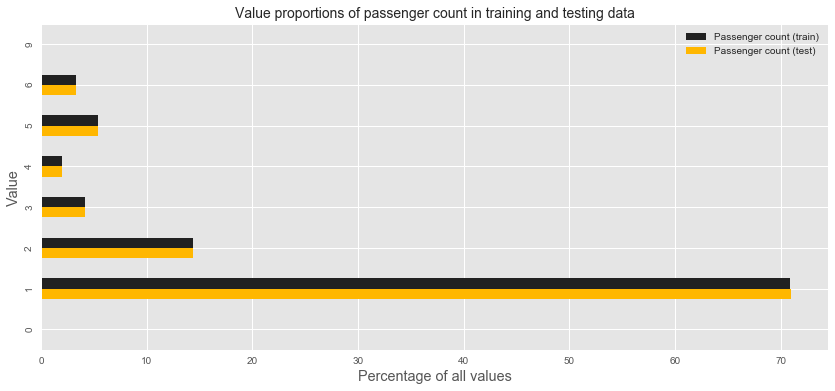

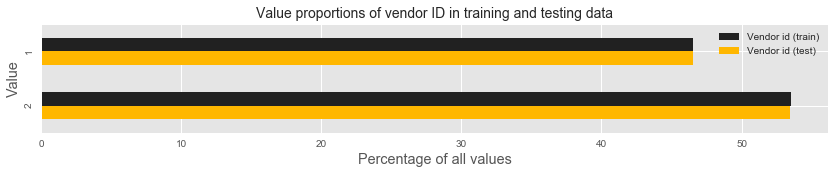

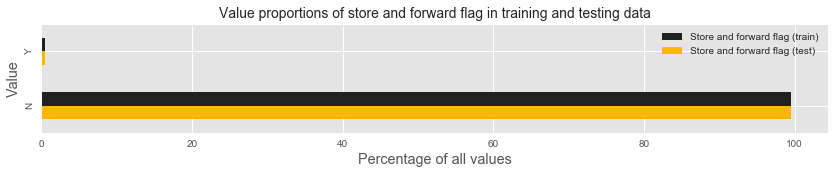

In [167]:
for col_name_pretty, col_name_official, figsize in zip(
        ['passenger count', 'vendor ID', 'store and forward flag'],
        ['passenger_count', 'vendor_id', 'store_and_fwd_flag'],
        [(14.1, 6), (14.1, 2), (14.1, 2)]):
    ax = pd.DataFrame({
        col_name_pretty.capitalize() + ' (train)':
            train[col_name_official].value_counts() /
            train[col_name_official].value_counts().sum() * 100,
        col_name_pretty.capitalize() + ' (test)':
            test[col_name_official].value_counts() /
            test[col_name_official].value_counts().sum() * 100}).plot.barh(
        figsize=figsize, legend='reverse', rot=90, stacked=False,
        color=[COLOR_YELLOW, COLOR_DARK])
    ax.set(xlabel='Percentage of all values', ylabel='Value')
    ax.set_title('Value proportions of %s in training and testing data' % col_name_pretty,
                 fontsize=14)

# Question:
# What are the value proportions of some varibales in training and testing data?

By looking at the above plots, we can make the following observations:

~70 % of the time people travel alone. The most popular way of sharing a taxi is to share it with a single friend. The second most popular way of sharing a taxi is to travel in a group of five people.

There are two vendors in the data, with the second vendor representing the majority.

Store and forward flag has almost always (99.4 % of the trips) been "No".

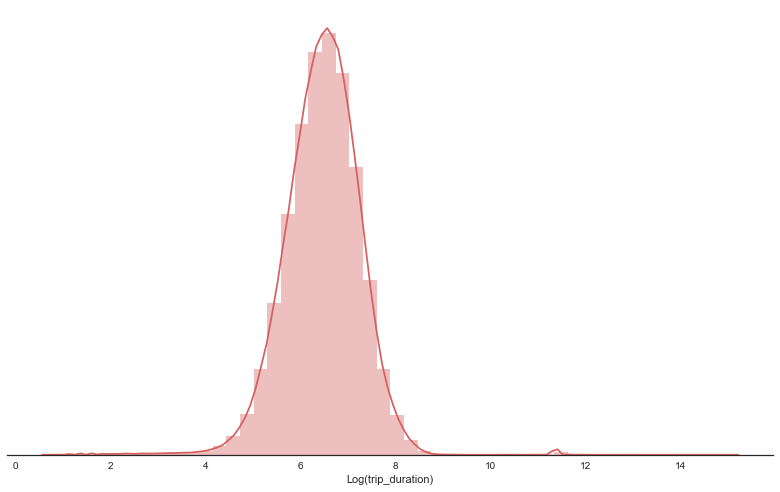

In [168]:
%matplotlib inline
import time
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()



# Question: Are trip durations like Gaussian?

It is clear with the above histogram and kernel density plot that the trip-durations are like Gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours (which is weird, as long as it isn't an intercity taxi ride from NYC to SF or Alaska)

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


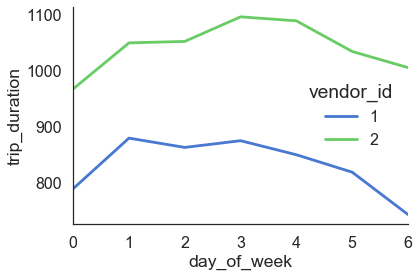

In [169]:
# Formatting datetime

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'week_of_year'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'day_of_year'] = train['pickup_datetime'].dt.dayofyear
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

# Finding:
    it's clear that the vendor 1 is taking more time than vendor 2 on all the days of the week.

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


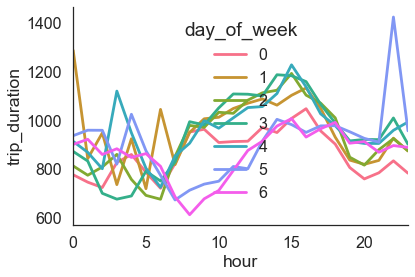

In [170]:
summary_hour_duration = pd.DataFrame(train.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

# findings -

Its clear from the above plot that on day 0, that is Sunday and day 6 that is Saturday, the trip duration is very less that all the weekdays at 5 AM to 15 AM time.
See this, on Saturday around midnight, the rides are taking far more than usual time, this is obvious through now verified using given data

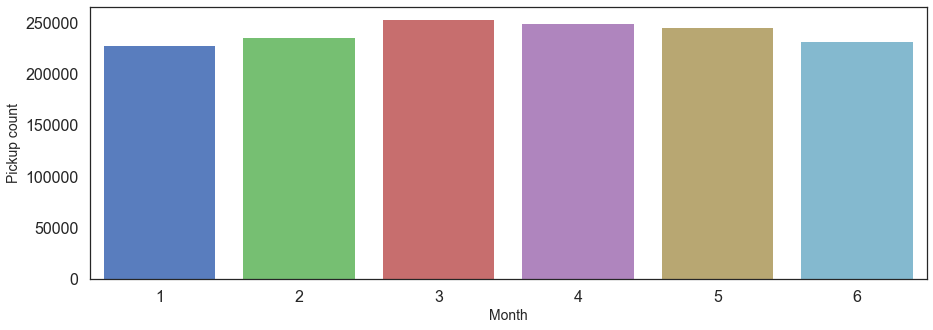

In [171]:
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour

train['drop_day'] = train['dropoff_datetime'].dt.day
train['drop_month'] = train['dropoff_datetime'].dt.month
train['drop_weekday'] = train['dropoff_datetime'].dt.weekday
train['drop_hour'] = train['dropoff_datetime'].dt.hour

f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

# Question: How many pickups for each month
Ans: See above bar graph

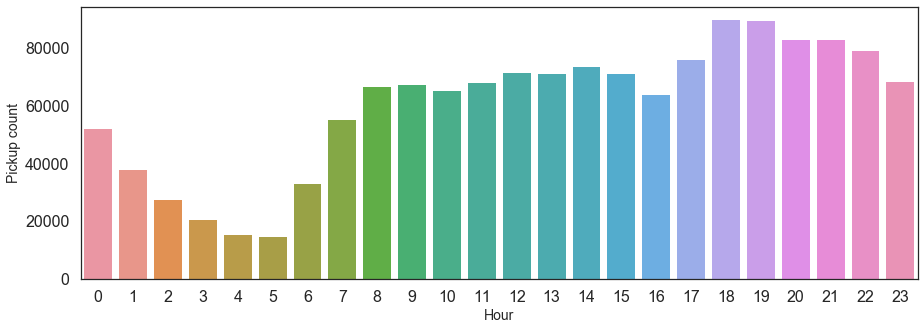

In [172]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

# Question: How many pickups/hr
Ans: See above bar graph. verything looks good here too. As expected, the number of pickups gradually decreases after mid-night. The highest number of pickups are around 6pm and 7pm in the evening which makes sense as many people are on their way to home from office.

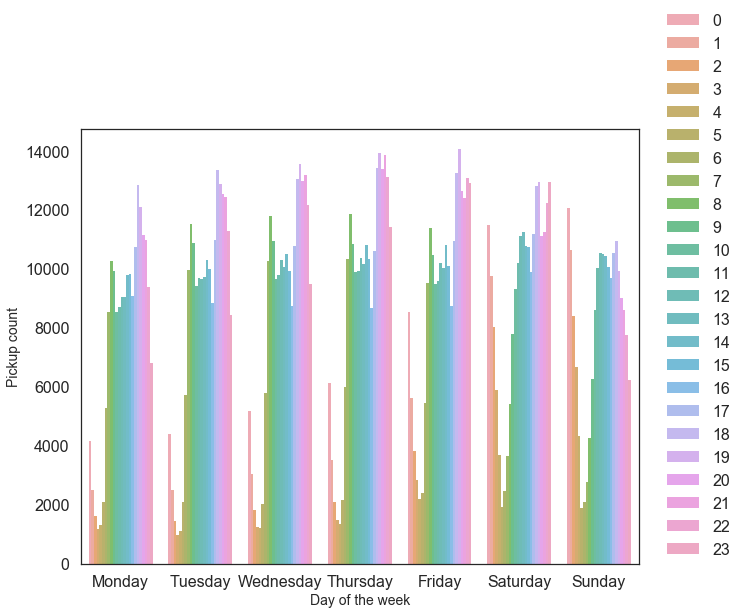

In [173]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train, hue='pickup_hour', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.legend(loc=(1.04,0))
plt.show()

Ahh nice plot. Did you notice the peaks at mid-night on Saturday and Sunday? This should be fine because most of the people are doing parties on weekends.

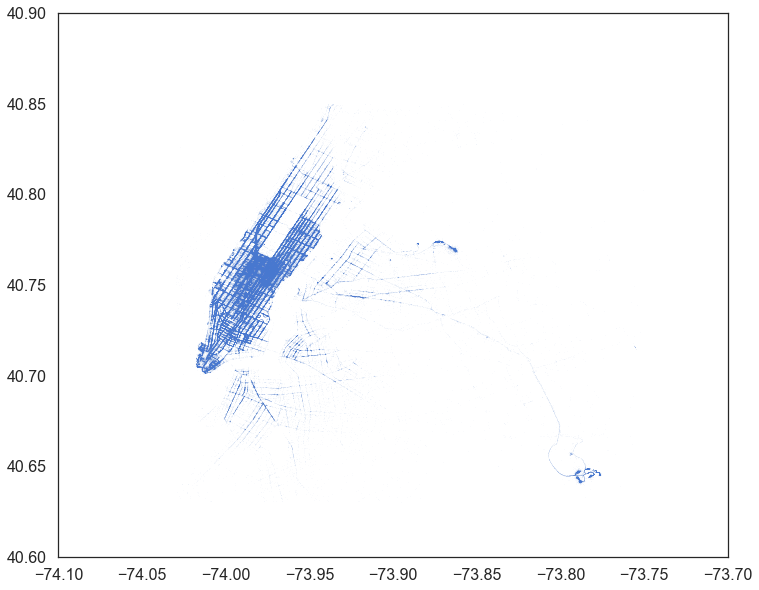

In [174]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.0002, alpha=1)

Yayyy!!! Finally a scatterplot...seems like most of the riders are taken within Manhatten..the other one at bottom right seems like area around JFK airport around Queens

# Lets check some correlations on the variables

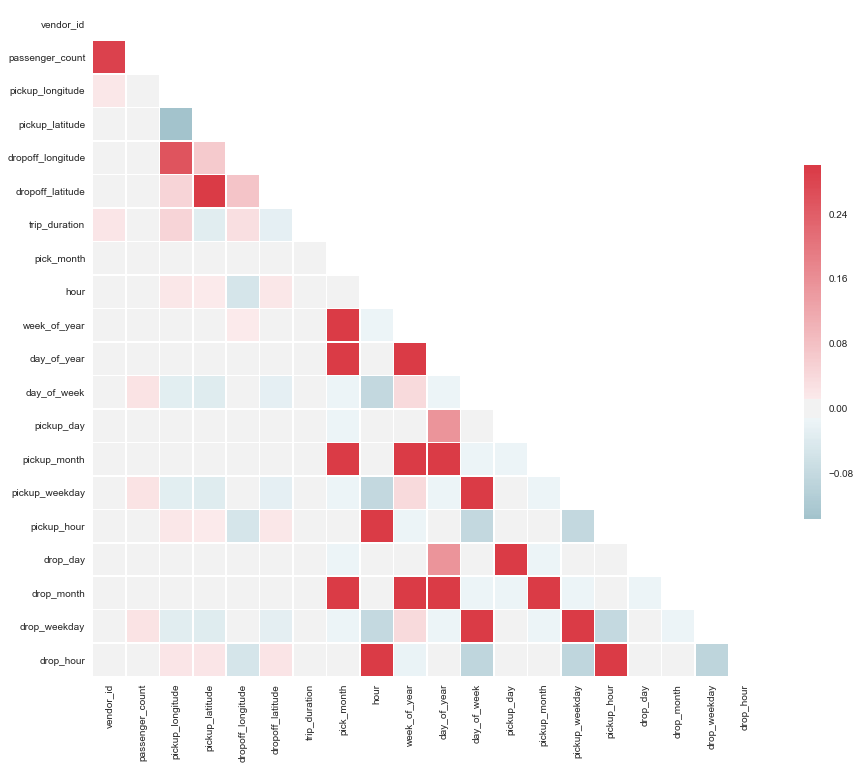

In [175]:
sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()

# Compute the correlation matrix
corr = temp3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Findings -

The highest correlation is observed with the gollowing variables:

    Week_of_year and pick_month
    day_of_year and pick_month
    trip_duration and pickup_longitude

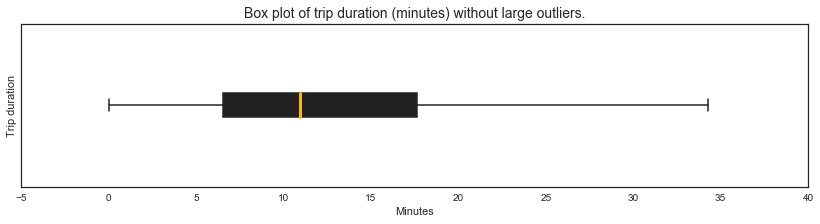

The duration of 95 % of the taxi trips was less than 35 minutes.
The median taxi trip duration was 10 minutes.
The shortest taxi trip duration was 1 second.
The longest taxi trip duration was 40 days and 19 hours.


In [176]:
trip_dur_mins = train['trip_duration'] / 60
figs = []
for var, var_name, y_range in zip([trip_dur_mins, np.log10(trip_dur_mins)],
                                  ["Trip duration (minutes)", "Log10(Trip duration (minutes))"],
                                  [(0, 15e5), (0, 2.5e5)]):
    # Calculate histogram
    counts, bin_edges = np.histogram(var, bins=50)
    # Generate colors for the histogram bars
    colormap = cm.get_cmap('hot')
    norm = colors.Normalize(vmax=np.max(np.array(counts)) + .5 * np.max(np.array(counts)),
                            vmin=np.min(np.array(counts)))
    hist_colors = [colors.rgb2hex(colormap(norm(n_vals))) for n_vals in counts]
    source = ColumnDataSource(data=dict(top=counts, bottom=[0] * counts.size,
                                        left=bin_edges[:-1], right=bin_edges[1:]))
    fig = figure(width=410, height=300,
                 tools=('wheel_zoom', 'pan', 'save, tap, reset', HoverTool(
                     tooltips=[(var_name.replace(" (minutes)", ""),
                                "@left-@right"), ("Count", "@top")])),
                 x_axis_location='below', toolbar_location="right", logo=None,
                 x_axis_label=var_name, y_axis_label='Count', y_range=y_range,
                 title="Histogram of %s" % var_name.lower())
    fig.quad(source=source, top='top', right='right', left='left', bottom='bottom')
    figs.append(fig)
show(row(figs))

# Plot the beginning of a boxplot of the original, non-normalized data
# to realize the skewness of the distribution
ax = plt.figure(figsize=(14.1, 3)).add_subplot(111)
boxplot = ax.boxplot(trip_dur_mins, vert=False, patch_artist=True, showfliers=False)
ax.set(xlabel='Minutes', ylabel='Trip duration', xlim=(-5, 40))
ax.get_yaxis().set_ticks([])
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(boxplot[item], color=COLOR_DARK, linewidth=1.5)
plt.setp(boxplot["medians"], color=COLOR_YELLOW, linewidth=3)
plt.title("Box plot of trip duration (minutes) without large outliers.", size=14)
plt.show();

# Print some statistics
print("The duration of %i %% of the taxi trips was less than 35 minutes." % 
      (100 * np.where(trip_dur_mins < 35)[0].size / train['trip_duration'].size))
print("The median taxi trip duration was %i minutes." % trip_dur_mins.median())
print("The shortest taxi trip duration was %i second." % train['trip_duration'].min())
print("The longest taxi trip duration was %i days and %i hours." % (
    np.floor(trip_dur_mins.max() / (60 * 24)),
    np.floor(trip_dur_mins.max() / (60 * 24) % 1 * 24)))

In the leftmost histogram, there is only one bar visible. There actually are other bars as well, but they are so tiny that we cannot see them without zooming in. This is due to the fact that the distribution of trip duration is positively skewed. It means that the majority of the taxi trips lasted a short time (<35 minutes), but there were exceptions where the trip lasted much longer such as the longest trip, which took 40 days and 19 hours (this must be an error in the data). Now, in the histogram on the right-hand side, there is  log10  transformed version of the same variable. Its distribution of values looks more normally distributed, which is one of the key assumptions of many methods in statistics. Because it is difficult to interpret log-transformed values, there is also a box plot of the non-transformed trip durations without outliers plotted under the histograms.

Next, let's use an interactive Folium map to visualize pickup and drop-off locations in the training data by plotting their clusters found by density based clustering algorithm DBSCAN. To speed up the computation, let's round latitudes and longitudes to four decimal places and remove duplicated entries. By rounding to four decimal places, we lose around 11 meters in accuracy. There are two hyperparameters in DBSCAN that we need to specify: eps and min_samples. eps or epsilon ( ϵ ) or radius defines the maximum distance between two samples for them to be considered as in the same cluster. min_samples is the number of samples in a neighborhood for a point to be considered as a core point (point at the interior of a cluster). There are approaches for choosing values for these hyperparameters, but here, they were chosen (eps = 400 meters, min_samples = 0.08 % of samples) by combining intuition and interpretation of the results.

In [177]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [178]:
%matplotlib inline
#!pip install xgboost
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [179]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [180]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

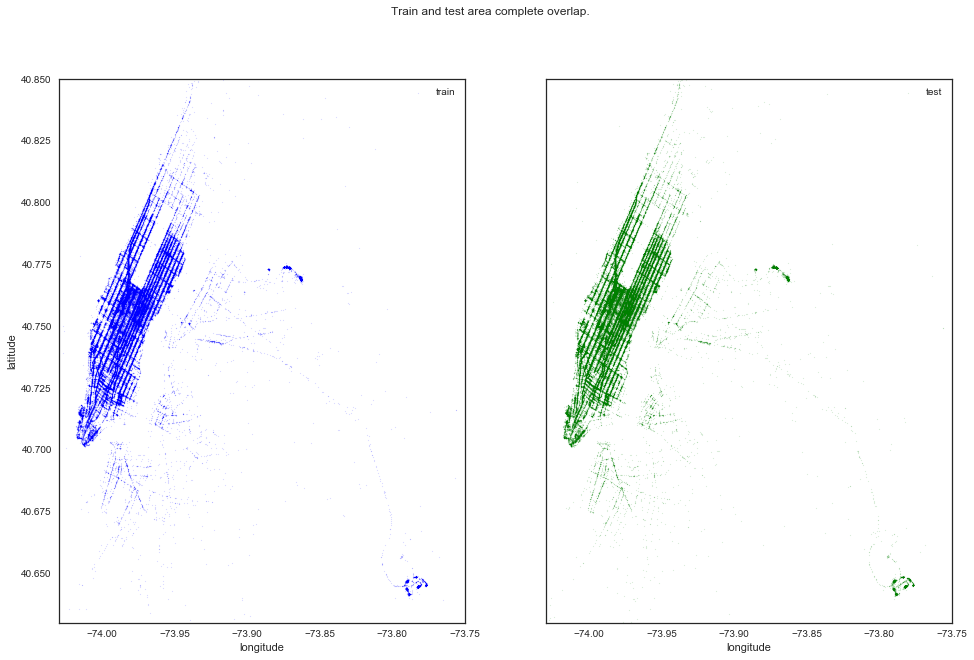

In [181]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

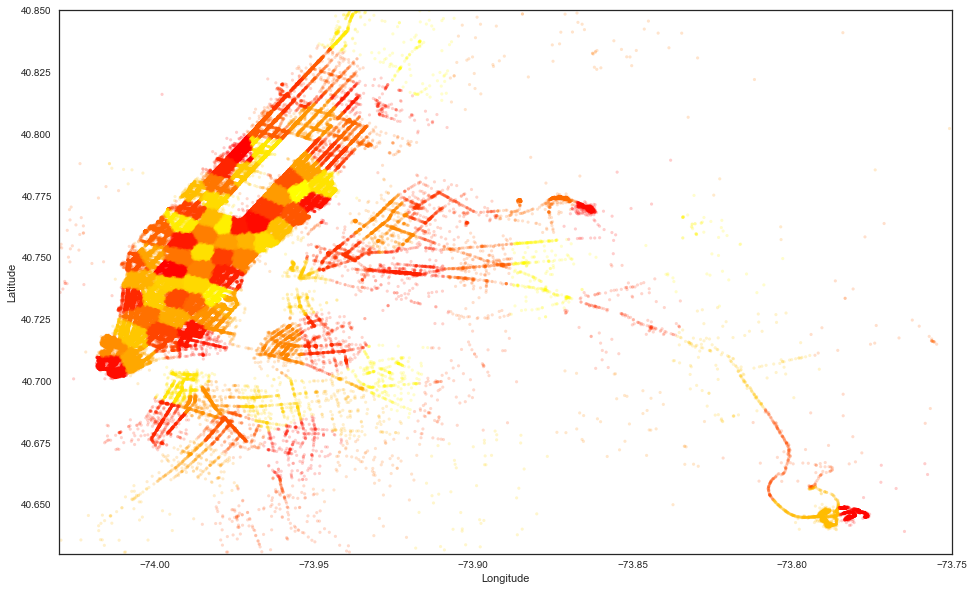

In [182]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

This shows a nice visual representation of the KMeans clustering algorithm at work (we used 100 clusters, but there is freedom to play around with this parameter to see how it changes the results). The clustering effectively created the different neighbourhoods in Manhattan as displayed by the borders between the different colors. This should be intuitive to some degree as a trip would differ from point A to point B, in various parts of New york. By nature, it's different.

The next step is to start looking into extracting information from the dates and starting to think about encoding the data.

In [183]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226764
 2    235370
 3    252812
 4    248210
 5    244940
 6    231087
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

Both train and test data sets have 6 months, so months are ready for dummy variables (i.e. encoding).

In [184]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

Both train and test data sets have 31 days, so days are ready for dummy variables (i.e. encoding).

In [185]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())



(24, 24)

In [186]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

So, excellent! We can safely use the different date parts in their extracted forms as part of the modelling process. Let's take a look at the average speed and how it changes over time, specifically focusing on how the hour of the day, the day of the week, and the moth of the year affects average speed. It's important to note though that average speed is a function of distance and time so it wouldn't add anything to the modelling output. We'll therefore need to remove it eventually before we train our model.

# Distance and Directionality

we can determine the distance and direction of a specific trip based on the pickup and dropoff coordinates.

In [189]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [190]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

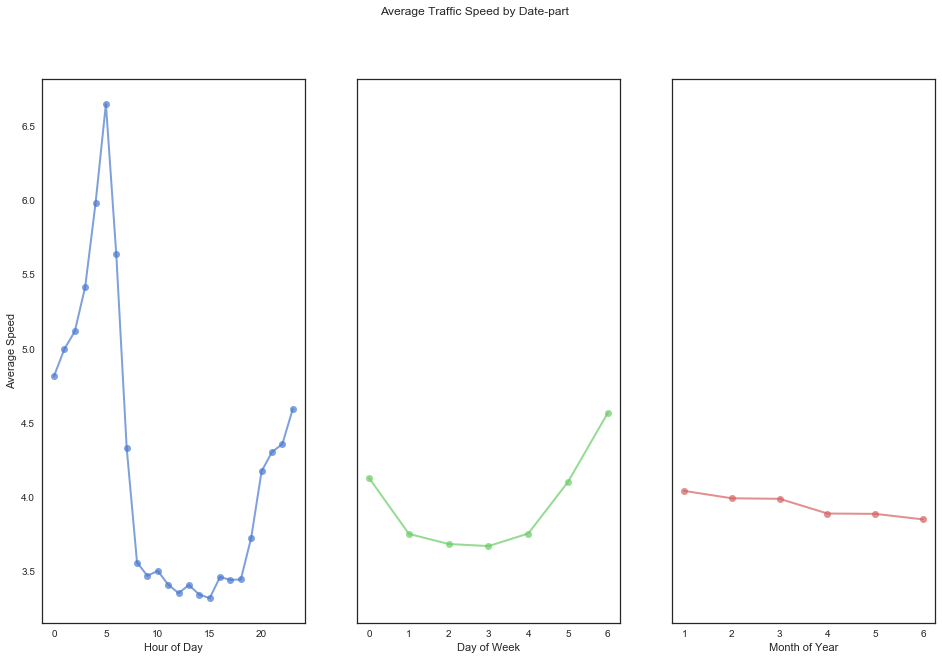

In [191]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [192]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

This next part uses the pick-up locations and the average speed data we've got and plots the average speed by location.

### Checking the output

In [193]:
vendor_train.shape,vendor_test.shape

((1439183, 2), (625134, 2))

In [48]:
passenger_count_train.shape,passenger_count_test.shape

((1439183, 7), (625134, 8))

In [49]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

((1439183, 2), (625134, 2))

In [50]:
cluster_pickup_train.shape,cluster_pickup_test.shape

((1439183, 100), (625134, 100))

In [53]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

((1439183, 100), (625134, 100))

Looking at the output you can tell that everything matches nicely, except for passenger count. We knew this however, since there were two trips with 9 passengers in the test set where there was no trips with 9 passengers in the train set. 
Like we concluded, this is clearly an error/outlier. Let's get rid of that:

In [194]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

And it would seem we've finally reached the end of what is easily considered the most difficult part of data science: cleaning and wrangling the data into a usable format/structure. The last part before we actually start training the model is to drop the categorical variables (since we replaced these with our indicator variables in the previous step) and compile the final version of our test and train sets.



In [196]:
train.shape,test.shape

((1439183, 23), (625134, 6))

### Now let's add the indicator variables to our datasets.

In [197]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [198]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [199]:
Train_Master.shape,Test_master.shape

((2064317, 302), (625134, 285))

The next step is to split the training set into sub-training and sub-testing sets. The reason for this is to be able to tweak model parameters to increase accuracy (i.e. decrease the root mean square error [RSME] value) without creating bias towards the test set. Also, and perhaps more importantly, is that we need a validation set to use with XGBoost. So the XGBoost algorithm takes three datasets: a training set, a test set, and a validation set. The validation set is used to continuously evaluate the accuracy of the training model, and finally the model is used to make predictions against the test set. So splitting out the training set into a separate train and test set gives us a test sample of which we know the outcome variables. 

We'll stick to 100 000 data points, this just makes the training process faster and a little less cumbersome to work with. Also, we'll split the training set into a 80-20 train and test set. So from this, there are two things you can do: change the ratios by which you split the original training set (`Train_Master`), e.g. use a 70-30 ratio and see what the results are. Also, you can include all the data points instead of just 100k. This should also have quite a siginficant effect on the outcome.


So the split would look something like this:

In [207]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

One more step and it really is time to start training: We need to create the XGBoost matrices that will be used to train the model using XGBoost. Note that we use the newly created test and train sets as our model training inputs (for train and validation) and finally use the master test set to make our predictions.

In [224]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
#Test['log_trip_duration'] = np.log(Test['trip_duration'].values + 1)
Train['log_trip_duration'] = np.log(Train['trip_duration'].values + 1)
Test['log_trip_duration'] = np.log(Test['trip_duration'].values + 1)

In [230]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('id',axis = 1)
Y_train = Y_train.reset_index().drop('id',axis = 1)

In [273]:
#X_test_1 = Test.drop(['pickup_datetime','dropoff_datetime'], axis=1)
#X_test = Test.drop(['pickup_datetime','dropoff_datetime'], axis=1)
#Test_master.drop(['pickup_datetime'], axis=1)
Test_master_1 = Test_master.drop(['pickup_datetime'], axis=1)

In [285]:
#dtrain = xgb.DMatrix(X_train, label=Y_train)
dtrain = xgb.DMatrix(X_train_2, label=Y_train)

dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master_1)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

## Training the model and testing the accuracy

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

The final step before submission is to make our predictions using the trained model:

In [ ]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1